<a href="https://colab.research.google.com/github/DanielPauliuchenka/SnakeAIGame/blob/main/CheXPert2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chexpert


In [ ]:
#@title Ячейка 1: Импорты и базовые настройки
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time

# Настройки
BASE_PATH = "/kaggle/input/chexpert/" # Путь к корневой папке датасета
TRAIN_CSV_PATH = os.path.join(BASE_PATH, "train.csv")
VALID_CSV_PATH = os.path.join(BASE_PATH, "valid.csv")
MODEL_SAVE_PATH = "/kaggle/working/" # Куда сохранять модели

# Гиперпараметры
IMG_SIZE = 224 # Размер изображения для модели
BATCH_SIZE = 32 # Уменьшите, если не хватает VRAM
NUM_EPOCHS = 10 # Для демонстрации, для реального обучения нужно больше
LEARNING_RATE = 1e-4

# Классы для предсказания (стандартные 14)
# Порядок важен, он должен соответствовать порядку колонок в CSV после фильтрации
CLASSES = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]
NUM_CLASSES = len(CLASSES)

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#@title Ячейка 2: Класс Dataset (с исправлением путей)
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # models импортируется позже
from PIL import Image
# Импорты для метрик и графиков лучше оставить в соответствующих ячейках

# Настройки из Ячейки 1 (для контекста, если запускать ячейку отдельно)
# BASE_PATH = "/kaggle/input/chexpert/" # или ваш актуальный путь
# TRAIN_CSV_PATH = os.path.join(BASE_PATH, "train.csv")
# VALID_CSV_PATH = os.path.join(BASE_PATH, "valid.csv")
# IMG_SIZE = 224
# CLASSES = [
#     'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
#     'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
#     'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
# ]
# BATCH_SIZE = 32


class CheXpertDataset(Dataset):
    def __init__(self, csv_file_path, base_path_for_images, image_transforms, uncertain_to_zero=True):
        self.df = pd.read_csv(csv_file_path)
        self.base_path_for_images = base_path_for_images # Это BASE_PATH из Ячейки 1
        self.image_transforms = image_transforms

        # Заполняем NaN значения (неопределенность)
        for col in CLASSES: # Убедитесь, что CLASSES определен глобально или передан
            if uncertain_to_zero:
                self.df[col] = self.df[col].fillna(0)
                self.df[col] = self.df[col].replace(-1.0, 0)
            else: # U-Ones
                self.df[col] = self.df[col].fillna(1)
                self.df[col] = self.df[col].replace(-1.0, 1)

        self.df[CLASSES] = self.df[CLASSES].astype(float).clip(0, 1)
        self.df = self.df[self.df['Path'].notna()]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path_relative_from_csv = self.df.iloc[idx]['Path'] # Например, "CheXpert-v1.0-small/train/patient..."

        # --- ИСПРАВЛЕНИЕ ПУТИ ---
        # Удаляем префикс типа "CheXpert-v1.0-small/" из пути в CSV,
        # так как base_path_for_images уже указывает на нужную корневую папку датасета.
        path_parts = img_path_relative_from_csv.replace('\\', '/').split('/') # Нормализуем слеши и разбиваем

        img_path_for_join = img_path_relative_from_csv # По умолчанию
        try:
            if 'train' in path_parts:
                start_index = path_parts.index('train')
                img_path_for_join = os.path.join(*path_parts[start_index:])
            elif 'valid' in path_parts:
                start_index = path_parts.index('valid')
                img_path_for_join = os.path.join(*path_parts[start_index:])
            else:
                # Если путь не содержит 'train' или 'valid' после ожидаемого префикса,
                # возможно, он уже в нужном формате или имеет другую структуру.
                # Для CheXpert это маловероятно, если CSV стандартный.
                # Оставляем как есть или можно добавить логирование.
                # print(f"Warning: Path '{img_path_relative_from_csv}' does not seem to follow 'prefix/train/...' or 'prefix/valid/...' structure after splitting.")
                # В данном случае, если префикс CheXpert-v1.0-small есть, а train/valid нет, то что-то совсем не так.
                # Но если префикса нет, а есть сразу train/..., то этот код отработает корректно.
                pass # img_path_for_join остается img_path_relative_from_csv

        except ValueError:
            # Это случится, если 'train' или 'valid' вообще нет в path_parts.
            # Это странно для стандартных CSV CheXpert.
            print(f"Warning: Could not find 'train' or 'valid' segment in CSV path: {img_path_relative_from_csv}. Using it as is.")
            # img_path_for_join остается img_path_relative_from_csv

        # Теперь img_path_for_join должен быть "train/patient..." или "valid/patient..."
        img_path_full = os.path.join(self.base_path_for_images, img_path_for_join)
        # ------------------------

        try:
            image = Image.open(img_path_full).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path_full}")
            print(f"  (Original CSV path: {img_path_relative_from_csv}, Processed path part for join: {img_path_for_join}, Base path for images: {self.base_path_for_images})")
            return None, None # Важно для collate_fn

        labels = torch.tensor(self.df.iloc[idx][CLASSES].values.astype(np.float32))

        if self.image_transforms:
            image = self.image_transforms(image)

        return image, labels

# --- Остальная часть Ячейки 2 (трансформации, создание датасетов и DataLoader'ов) ---
# Убедитесь, что переменные BASE_PATH, TRAIN_CSV_PATH, VALID_CSV_PATH, IMG_SIZE, CLASSES, BATCH_SIZE
# определены в Ячейке 1 или переданы/доступны здесь.

# Трансформации изображений (если не определены ранее)
if 'train_transforms' not in globals(): # Проверка, чтобы не переопределять, если ячейка запускается повторно
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Создание датасетов
# Конструктор теперь CheXpertDataset(csv_file_path, base_path_for_images, ...)
# csv_file_path - это TRAIN_CSV_PATH / VALID_CSV_PATH
# base_path_for_images - это BASE_PATH
train_dataset = CheXpertDataset(TRAIN_CSV_PATH, BASE_PATH, train_transforms, uncertain_to_zero=True)
valid_dataset = CheXpertDataset(VALID_CSV_PATH, BASE_PATH, valid_transforms, uncertain_to_zero=True)


print(f"Размер обучающего датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(valid_dataset)}")

if len(train_dataset) > 0:
    # Проверка первого элемента (если он есть и загружается)
    try:
        idx_check = 0
        sample_img, sample_labels = None, None
        # Ищем первый валидный сэмпл, если первые несколько не загружаются
        while idx_check < len(train_dataset):
            sample_img, sample_labels = train_dataset[idx_check]
            if sample_img is not None:
                break
            idx_check += 1

        if sample_img is not None:
            print("Форма изображения (первый валидный сэмпл):", sample_img.shape)
            print("Метки (первый валидный сэмпл):", sample_labels)
        else:
            print("Не удалось загрузить ни один сэмпл из train_dataset для проверки.")
    except Exception as e:
        print(f"Ошибка при получении сэмпла из train_dataset: {e}")
else:
    print("Обучающий датасет пуст.")


# Collate function для обработки возможных None значений из Dataset
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f"Количество батчей в train_loader: {len(train_loader)}")
print(f"Количество батчей в valid_loader: {len(valid_loader)}")

Размер обучающего датасета: 223414
Размер валидационного датасета: 234
Форма изображения (первый валидный сэмпл): torch.Size([3, 224, 224])
Метки (первый валидный сэмпл): tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Количество батчей в train_loader: 3491
Количество батчей в valid_loader: 4


In [ ]:
#@title Ячейка 3: Определение модели
def get_model(num_classes, pretrained=True):
    model = models.densenet121(pretrained=pretrained)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, num_classes),
        # nn.Sigmoid() # BCEWithLogitsLoss уже включает sigmoid
    )
    return model

model = get_model(NUM_CLASSES).to(device)
# print(model) # Раскомментируйте, чтобы увидеть архитектуру модели

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#@title Ячейка 4: Функция потерь, оптимизатор и функция для расчета AUC
criterion = nn.BCEWithLogitsLoss() # Подходит для мульти-лейбл классификации
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True) # Для AUC 'max'

def calculate_auc(y_true_all, y_pred_all, class_names):
    """Рассчитывает AUC для каждого класса и средний AUC."""
    auc_scores = {}
    for i, class_name in enumerate(class_names):
        try:
            # Убедимся, что есть как минимум один положительный и один отрицательный пример
            if len(np.unique(y_true_all[:, i])) > 1:
                 auc_scores[class_name] = roc_auc_score(y_true_all[:, i], y_pred_all[:, i])
            else:
                auc_scores[class_name] = np.nan # или 0.5, если хотим считать отсутствие вариативности как случайное гадание
        except ValueError as e:
            print(f"Could not calculate AUC for class {class_name}: {e}")
            auc_scores[class_name] = np.nan

    valid_aucs = [auc for auc in auc_scores.values() if not np.isnan(auc)]
    if valid_aucs:
        avg_auc = np.mean(valid_aucs)
    else:
        avg_auc = 0.0

    return avg_auc, auc_scores

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
#@title Ячейка 5: Цикл обучения и валидации
best_valid_auc = 0.0
train_losses = []
valid_losses = []
valid_aucs_history = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # --- Обучение ---
    model.train()
    running_loss_train = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if images.nelement() == 0: # Пропуск пустого батча
            print(f"Skipping empty batch in train_loader at step {i}")
            continue
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item() * images.size(0)

        if (i + 1) % 100 == 0: # Логирование каждые 100 батчей
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    # --- Валидация ---
    model.eval()
    running_loss_valid = 0.0
    all_labels_valid = []
    all_preds_valid = []

    with torch.no_grad():
        for images, labels in valid_loader:
            if images.nelement() == 0: # Пропуск пустого батча
                print(f"Skipping empty batch in valid_loader")
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_valid += loss.item() * images.size(0)

            all_labels_valid.append(labels.cpu().numpy())
            all_preds_valid.append(torch.sigmoid(outputs).cpu().numpy()) # Применяем sigmoid для получения вероятностей

    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
    valid_losses.append(epoch_loss_valid)

    all_labels_valid_np = np.concatenate(all_labels_valid, axis=0)
    all_preds_valid_np = np.concatenate(all_preds_valid, axis=0)

    avg_auc, auc_scores_valid = calculate_auc(all_labels_valid_np, all_preds_valid_np, CLASSES)
    valid_aucs_history.append(avg_auc)

    scheduler.step(avg_auc) # Для ReduceLROnPlateau

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_time:.0f}s] -> "
          f"Train Loss: {epoch_loss_train:.4f}, Valid Loss: {epoch_loss_valid:.4f}, "
          f"Valid Avg AUC: {avg_auc:.4f}")

    print("Validation AUCs per class:")
    for cls_name, auc_val in auc_scores_valid.items():
        print(f"  - {cls_name}: {auc_val:.4f}")

    # Сохранение лучшей модели
    if avg_auc > best_valid_auc:
        best_valid_auc = avg_auc
        model_path = os.path.join(MODEL_SAVE_PATH, f"chexpert_densenet121_best_auc_epoch{epoch+1}_auc{avg_auc:.4f}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path} (AUC: {avg_auc:.4f})")

# Сохранение последней модели
final_model_path = os.path.join(MODEL_SAVE_PATH, "chexpert_densenet121_final.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

Epoch [1/10], Step [100/3491], Train Loss: 0.3142
Epoch [1/10], Step [200/3491], Train Loss: 0.3334
Epoch [1/10], Step [300/3491], Train Loss: 0.2854
Epoch [1/10], Step [400/3491], Train Loss: 0.3077
Epoch [1/10], Step [500/3491], Train Loss: 0.2961
Epoch [1/10], Step [600/3491], Train Loss: 0.3304
Epoch [1/10], Step [700/3491], Train Loss: 0.2886
Epoch [1/10], Step [800/3491], Train Loss: 0.2838
Epoch [1/10], Step [900/3491], Train Loss: 0.2709
Epoch [1/10], Step [1000/3491], Train Loss: 0.3039
Epoch [1/10], Step [1100/3491], Train Loss: 0.2650
Epoch [1/10], Step [1200/3491], Train Loss: 0.3114
Epoch [1/10], Step [1300/3491], Train Loss: 0.2964
Epoch [1/10], Step [1400/3491], Train Loss: 0.2790
Epoch [1/10], Step [1500/3491], Train Loss: 0.2760
Epoch [1/10], Step [1600/3491], Train Loss: 0.3072
Epoch [1/10], Step [1700/3491], Train Loss: 0.2911
Epoch [1/10], Step [1800/3491], Train Loss: 0.2486
Epoch [1/10], Step [1900/3491], Train Loss: 0.2924
Epoch [1/10], Step [2000/3491], Train Lo

In [ ]:
from google.colab import files
files.download('chexpert_densenet121_final.pth')

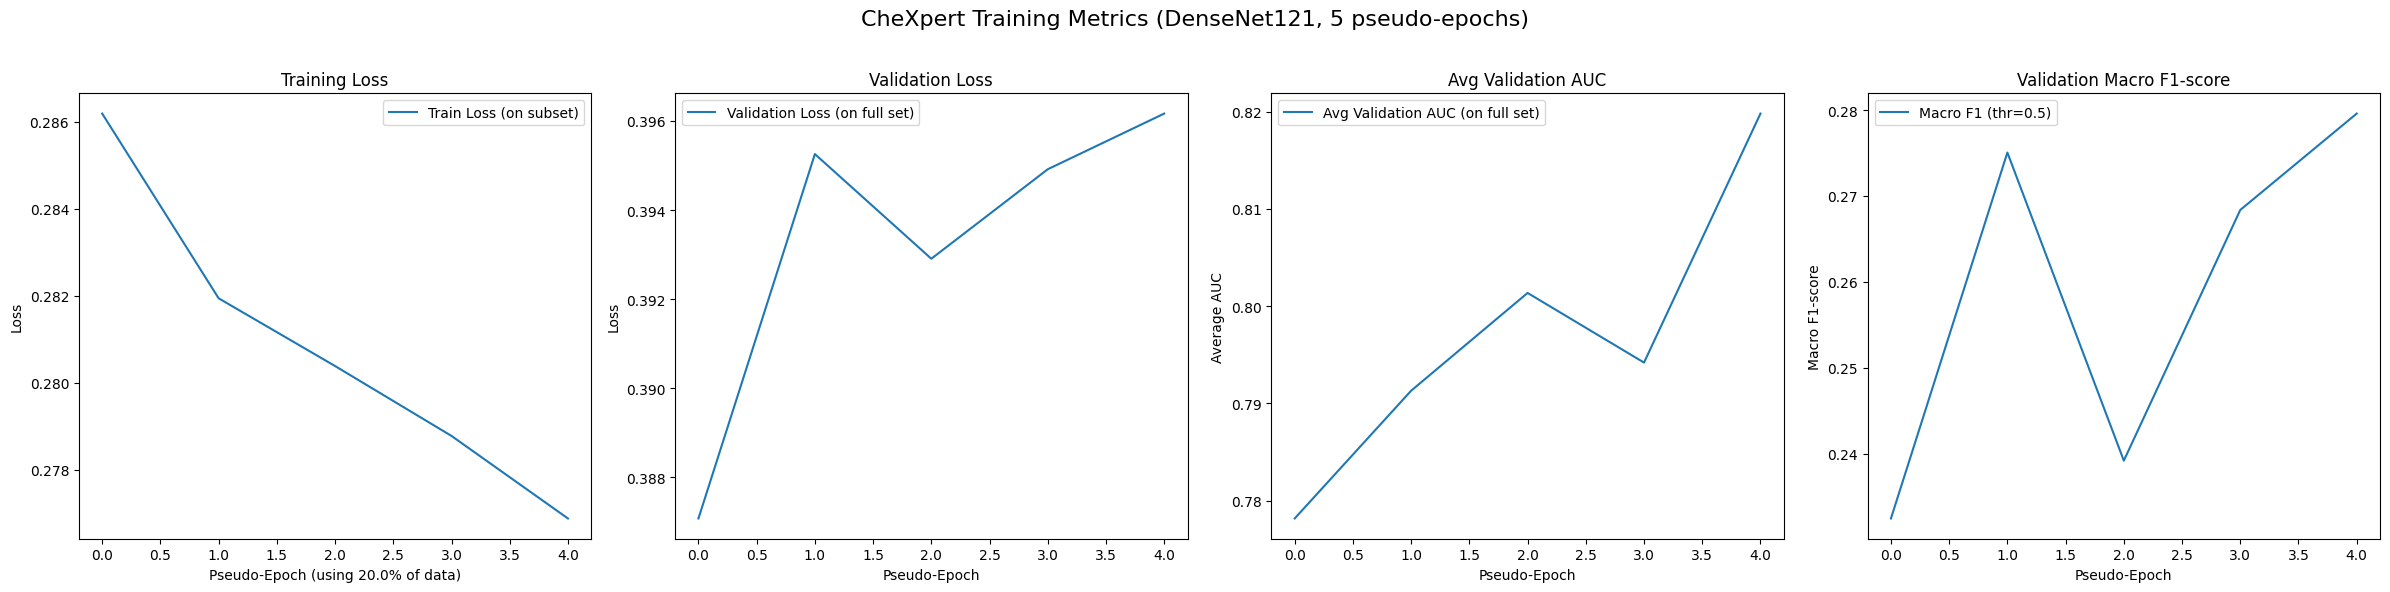

Best Validation Average AUC (corresponding to best F1): 0.8198
Best Validation Macro F1 (threshold 0.5): 0.2796
Final Training Loss (on subset): 0.2769
Final Validation Loss: 0.3962
Final Validation Avg AUC: 0.8198
Final Validation Macro F1: 0.2796


In [ ]:
#@title Ячейка 6: Визуализация результатов (потери и AUC)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_aucs_history, label='Validation Avg AUC')
plt.xlabel('Epoch')
plt.ylabel('Average AUC')
plt.title('Average Validation AUC vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best Validation Average AUC: {best_valid_auc:.4f}")